# IMPORTS

In [1]:
import glob
from selenium.webdriver.edge.service import Service as EdgeService
from selenium import webdriver
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from selenium.webdriver.common.by import By
from selenium.webdriver.edge.options import Options
import time
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import json
import fitz
import re
import os
from datetime import datetime
# code qui extrait les isin
# on mets les isin dans un fichier json
# on extrait isin du fichier json et on les mets dans une liste
# on parcours la liste et on extrait les symboles de l'url boursorama
# on dl les prix de cloture pour chaque et les mets dans un big dataframe
# on supprime les fichiers individuels et garde que le big dataframe


### On extrait les ISIN

In [19]:
def extract_isin_from_pdf(pdf_path):
    """
    Extrait les codes ISIN d'un fichier PDF.
    """
    doc = fitz.open(pdf_path)
    isin_codes = set()

    #codes ISIN
    pattern = re.compile(r'\b[A-Z]{2}[A-Z0-9]{8}[0-9]{2}\b')

    for page in doc:

        # Extraction des codes isin du texte de la page
        text = page.get_text()
        found_codes = re.findall(pattern, text)
        isin_codes.update(found_codes)

    # Suppression des doublons
    isin_codes = list(set(isin_codes))

    return isin_codes

In [41]:
extraction = extract_isin_from_pdf("GeneraliPatrimoine.pdf")
with open('GeneraliPatrimoine.json', 'w') as fichier:
    json.dump(extraction, fichier)

In [2]:
isins = []
with open('GeneraliPatrimoine.json', 'r') as fichier:
    isins = json.load(fichier) 
isins

['DE000BAY0017',
 'IE000R85HL30',
 'FR0013167293',
 'LU0171290074',
 'LU0050372472',
 'FR0010058008',
 'FR0000120073',
 'FR0000121964',
 'LU2207968921',
 'LU0225737302',
 'FR0013161965',
 'LU0340554913',
 'LU1876459303',
 'LU0389812933',
 'FR0010315770',
 'LU2023678878',
 'IE00BKM4GZ66',
 'LU2270409126',
 'FR0011799931',
 'LU1834988609',
 'LU0987487336',
 'FR0010493957',
 'FR0010679902',
 'LU1834983550',
 'FR0007494778',
 'FR0010045625',
 'LU0384368212',
 'FR0011170182',
 'FR0013258340',
 'LU1951200481',
 'FR0013400546',
 'IE00B86MWN23',
 'FR0010109140',
 'FR0011271576',
 'LU0147918923',
 'LU0088087324',
 'FR0010772129',
 'LU0599946893',
 'FR0000931362',
 'FR0013281193',
 'FR0013309226',
 'FR0010434019',
 'LU0912262275',
 'IE0000829238',
 'FR0010738153',
 'LU0187079347',
 'LU0218171717',
 'FR0010046367',
 'LU0231118026',
 'FR0010637488',
 'FR0013339538',
 'FR0012070100',
 'FR0010249672',
 'LU0147944259',
 'FR0010429068',
 'LU1213836080',
 'LU0266117927',
 'FR0010349977',
 'LU0252633754

Webscraping

In [38]:
dix_ans = "C:\\Users\\Irish\\Desktop\\Informatique\\Python\\Pi2\\ISINS_plus_de_dix_ans"
cinq_ans = "C:\\Users\\Irish\\Desktop\\Informatique\\Python\\Pi2\\ISINS_plus_de_cinq_ans"
trois_ans = "C:\\Users\\Irish\\Desktop\\Informatique\\Python\\Pi2\\ISINS_plus_de_trois_ans"


In [3]:
# Set up the Edge driver
msedgedriver_path = "C:\\Users\\Irish\\Desktop\\Informatique\\Python\\Pi2\\msedgedriver.exe"

#server_path = "C:/Users/Irish/Desktop/Informatique/Python/Pi2/browsermob-proxy-2.1.4/bin/browsermob-proxy.bat"

#server = Server(server_path)
#server.start()
download_dir = "C:\\Users\\Irish\\Desktop\\Informatique\\Python\\Pi2\\ISINS"


os.makedirs(download_dir, exist_ok=True)

options = Options()
options.add_argument("--incognito")
options.add_argument("--disable-notifications")
options.add_argument("--ignore-certificate-errors")
prefs = {
    "download.default_directory": download_dir,
    "download.prompt_for_download": False,
    "download.directory_upgrade": True,
    "safebrowsing.enabled": True
}
options.add_experimental_option("prefs", prefs)



In [4]:
def lire_date_ancienne(fichier):
    with open(fichier, 'r') as f:
        dates = []
        for ligne in f:
            if ligne.strip() and not ligne.startswith('date'):
                try:
                    # Essayer de convertir la première colonne en date
                    date = datetime.strptime(ligne.split()[0], '%d/%m/%Y')
                    dates.append(date)
                except ValueError:
                    # Ignorer les lignes qui ne correspondent pas au format de date
                    continue
        return min(dates) if dates else None

In [5]:
dossier_source = "C:\\Users\\Irish\\Desktop\\Informatique\\Python\\Pi2\\ISINS"
dossier_destination = "C:\\Users\\Irish\\Desktop\\Informatique\\Python\\Pi2\\ISINS"

In [6]:

edge_service = EdgeService(executable_path=msedgedriver_path)
driver = webdriver.Edge(service=edge_service, options=options)

search_url = "https://www.boursorama.com/recherche"
dl_url = "https://www.boursorama.com/bourse/action/graph/ws/download?length=3650&period=-1&symbol={}"


driver.get("https://www.boursorama.com/")
wait = WebDriverWait(driver, 5)
accept_button = wait.until(EC.element_to_be_clickable((By.CSS_SELECTOR, '#didomi-notice-agree-button')))
accept_button.click()
nb_of_isins = 0
for isin in isins:
    start_time = time.time()
    driver.get(search_url)
    search_box = driver.find_element(By.ID, "search_query")
    search_box.send_keys(str(isin))
    search_button = driver.find_element(By.ID, 'search_search')
    search_button.click()
    symbol =  driver.current_url.strip('/').split('/')[-1]
    driver.get(dl_url.format(symbol))
    print(f"Time taken: {time.time() - start_time} seconds, for {isin}")
    txt_file_found = False
    while not txt_file_found:
        for filename in os.listdir(dossier_source):
            if filename.endswith('.txt') or filename.endswith('.tx'):
                txt_file_found = True
                break 
    for fichier in os.listdir(dossier_source):
        if fichier.endswith('.txt') or fichier.endswith('.tx'):
            chemin_fichier = os.path.join(dossier_source, fichier)
    
            new_file_name = f"{isin}.txt"
            new_file_path = os.path.join(dossier_source, new_file_name)
            os.rename(chemin_fichier, new_file_path)
            print(chemin_fichier, "to", new_file_path)
            date_ancienne = lire_date_ancienne(new_file_path)
            if date_ancienne:
                anciennete = (datetime.now() - date_ancienne).days / 365.25
                if anciennete > 10:
                    dossier_cible = os.path.join(dossier_destination, 'plus_de_10_ans')
                elif anciennete > 5:
                    dossier_cible = os.path.join(dossier_destination, 'plus_de_5_ans')
                elif anciennete > 3:
                    dossier_cible = os.path.join(dossier_destination, 'plus_de_3_ans')
                else:
                    dossier_cible = os.path.join(dossier_destination, 'moins_de_3_ans')
                if not os.path.exists(dossier_cible):
                    os.makedirs(dossier_cible)
                final_file_path = os.path.join(dossier_cible, new_file_name)
                os.rename(new_file_path, final_file_path)
                print(new_file_path, "to", final_file_path)


driver.wait(10)
driver.quit()

Time taken: 52.700791120529175 seconds, for DE000BAY0017
C:\Users\Irish\Desktop\Informatique\Python\Pi2\ISINS\BAYER_2024-03-16.txt to C:\Users\Irish\Desktop\Informatique\Python\Pi2\ISINS\DE000BAY0017.txt
C:\Users\Irish\Desktop\Informatique\Python\Pi2\ISINS\DE000BAY0017.txt to C:\Users\Irish\Desktop\Informatique\Python\Pi2\ISINS\plus_de_5_ans\DE000BAY0017.txt
Time taken: 12.056471824645996 seconds, for IE000R85HL30
C:\Users\Irish\Desktop\Informatique\Python\Pi2\ISINS\AMUNDIMSCIUSASRICLIMATENETZEROAMBITIONPABUCITSETFC_2024-03-16.tx to C:\Users\Irish\Desktop\Informatique\Python\Pi2\ISINS\IE000R85HL30.txt
C:\Users\Irish\Desktop\Informatique\Python\Pi2\ISINS\IE000R85HL30.txt to C:\Users\Irish\Desktop\Informatique\Python\Pi2\ISINS\plus_de_5_ans\IE000R85HL30.txt
Time taken: 10.542124032974243 seconds, for FR0013167293
C:\Users\Irish\Desktop\Informatique\Python\Pi2\ISINS\OPCIFRANCEUROPEIMMOISRB_2024-03-16.txt to C:\Users\Irish\Desktop\Informatique\Python\Pi2\ISINS\FR0013167293.txt
C:\Users\Iri

FileExistsError: [WinError 183] Impossible de créer un fichier déjà existant: 'C:\\Users\\Irish\\Desktop\\Informatique\\Python\\Pi2\\ISINS\\LAZARDHORIZON20222024_2024-03-16.txt' -> 'C:\\Users\\Irish\\Desktop\\Informatique\\Python\\Pi2\\ISINS\\FR0010046367.txt'

METTRE LES FICHIERS DANS 4 DOSSIERS DIFFERENTS

In [35]:
for fichier in os.listdir(dossier_source):
    chemin_fichier = os.path.join(dossier_source, fichier)
    date_ancienne = lire_date_ancienne(chemin_fichier)
    
    if date_ancienne:
        anciennete = (datetime.now() - date_ancienne).days / 365.25
        
        if anciennete > 10:
            dossier_cible = os.path.join(dossier_destination, 'plus_de_10_ans')
        elif anciennete > 5:
            dossier_cible = os.path.join(dossier_destination, 'plus_de_5_ans')
        elif anciennete > 3:
            dossier_cible = os.path.join(dossier_destination, 'plus_de_3_ans')
        else:
            dossier_cible = os.path.join(dossier_destination, 'moins_de_3_ans')  # Si moins de 3 ans, on ne déplace pas le fichier
        
        if not os.path.exists(dossier_cible):
            os.makedirs(dossier_cible)
        
        os.rename(chemin_fichier, os.path.join(dossier_cible, fichier))

1
2021-05-04 00:00:00
2021-05-05 00:00:00
2021-05-06 00:00:00
2021-05-07 00:00:00
2021-05-10 00:00:00
2021-05-11 00:00:00
2021-05-12 00:00:00
2021-05-14 00:00:00
2021-05-17 00:00:00
2021-05-18 00:00:00
2021-05-19 00:00:00
2021-05-20 00:00:00
2021-05-21 00:00:00
2021-05-25 00:00:00
2021-05-26 00:00:00
2021-05-27 00:00:00
2021-05-28 00:00:00
2021-05-31 00:00:00
2021-06-01 00:00:00
2021-06-02 00:00:00
2021-06-03 00:00:00
2021-06-04 00:00:00
2021-06-07 00:00:00
2021-06-08 00:00:00
2021-06-09 00:00:00
2021-06-10 00:00:00
2021-06-11 00:00:00
2021-06-14 00:00:00
2021-06-15 00:00:00
2021-06-16 00:00:00
2021-06-17 00:00:00
2021-06-18 00:00:00
2021-06-21 00:00:00
2021-06-22 00:00:00
2021-06-24 00:00:00
2021-06-25 00:00:00
2021-06-28 00:00:00
2021-06-29 00:00:00
2021-06-30 00:00:00
2021-07-01 00:00:00
2021-07-02 00:00:00
2021-07-05 00:00:00
2021-07-06 00:00:00
2021-07-07 00:00:00
2021-07-08 00:00:00
2021-07-09 00:00:00
2021-07-12 00:00:00
2021-07-13 00:00:00
2021-07-14 00:00:00
2021-07-15 00:00:0

PermissionError: [Errno 13] Permission denied: 'C:\\Users\\Irish\\Desktop\\Informatique\\Python\\Pi2\\ISINS\\plus_de_10_ans'

In [80]:
df_m3y = pd.DataFrame()
df_3y = pd.DataFrame()
df_5y = pd.DataFrame()
df_10y = pd.DataFrame()

path_m3y = "C:/Users/Irish/Desktop/Informatique/Python/Pi2/ISINS/moins_de_3_ans"
path_3y = "C:/Users/Irish/Desktop/Informatique/Python/Pi2/ISINS/plus_de_3_ans"
path_5y = "C:/Users/Irish/Desktop/Informatique/Python/Pi2/ISINS/plus_de_5_ans"
path_10y = "C:/Users/Irish/Desktop/Informatique/Python/Pi2/ISINS/plus_de_10_ans"

count_m3y = sum(os.path.isfile(os.path.join(path_m3y, entry)) for entry in (os.listdir(path_m3y)))
count_3y = sum(os.path.isfile(os.path.join(path_3y, entry)) for entry in (os.listdir(path_3y)))
count_5y = sum(os.path.isfile(os.path.join(path_5y, entry)) for entry in (os.listdir(path_5y)))
count_10y = sum(os.path.isfile(os.path.join(path_10y, entry)) for entry in (os.listdir(path_10y)))

txt_m3y = glob.glob(f"{path_m3y}/*.txt")
txt_3y = glob.glob(f"{path_3y}/*.txt")
txt_5y = glob.glob(f"{path_5y}/*.txt")
txt_10y = glob.glob(f"{path_10y}/*.txt")

isins_m3y = []
isins_3y = []
isins_5y = []
isins_10y = []
k = 0

DATAFRAME PLUS DE 10ANS

In [81]:
k = 0
for filename in os.listdir(path_10y):
    if filename.endswith('.txt'):
        isin = filename.split('.')[0]
        isins_10y.append(isin)
# Parcours chaque ISIN
for isin in isins_10y[:count_10y]:
    stock_df = pd.read_csv(txt_10y[k], sep='\t', parse_dates=['date'], dayfirst=True)
    closing_price_df = stock_df[['date', 'clot']].copy()
    closing_price_df.rename(columns={'clot': isin}, inplace=True)
    if df_10y.empty:
        df_10y = closing_price_df
    else:
        df_10y = pd.merge(df_10y, closing_price_df, on='date', how='outer')
    k += 1
   
    df_10y.sort_values('date', inplace=True)
    df_10y.reset_index(drop=True, inplace=True)
#shutil.rmtree(download_dir)
df_10y.set_index('date', inplace=True)
df_10y

,DE000BAY0017,FR0010058008,LU0050372472,LU0171290074
date,,,,
2014-03-10,94.907,203.81,25.13,5.75
2014-03-11,94.109,204.42,25.12,5.77
2014-03-12,93.932,202.73,25.15,5.65
2014-03-13,91.639,200.72,25.15,5.63
2014-03-14,93.539,198.97,25.18,5.57
...,...,...,...,...
2024-03-04,28.080,289.52,26.49,13.50
2024-03-05,25.955,289.60,26.64,13.47
2024-03-06,26.645,290.80,26.65,13.47


In [82]:
df_10y

,DE000BAY0017,FR0010058008,LU0050372472,LU0171290074
date,,,,
2014-03-10,94.907,203.81,25.13,5.75
2014-03-11,94.109,204.42,25.12,5.77
2014-03-12,93.932,202.73,25.15,5.65
2014-03-13,91.639,200.72,25.15,5.63
2014-03-14,93.539,198.97,25.18,5.57
...,...,...,...,...
2024-03-04,28.080,289.52,26.49,13.50
2024-03-05,25.955,289.60,26.64,13.47
2024-03-06,26.645,290.80,26.65,13.47


In [4]:
big_df = pd.DataFrame()
directory_path = "C:/Users/Irish/Desktop/Informatique/Python/Pi2/ISINS"
nb_of_isins = 26

txt_files = glob.glob(f"{directory_path}/*.txt")
k = 0
# On boucle sur tous les ISINS
for isin in isins[:nb_of_isins-1]:
    stock_df = pd.read_csv(txt_files[k], sep='\t', parse_dates=['date'], dayfirst=True)
    closing_price_df = stock_df[['date', 'clot']].copy()
    closing_price_df.rename(columns={'clot': isin}, inplace=True)
    if big_df.empty:
        big_df = closing_price_df
    else:
        big_df = pd.merge(big_df, closing_price_df, on='date', how='outer')
    k += 1
    # Sort and reset index after merging all files for the current ISIN
    big_df.sort_values('date', inplace=True)
    big_df.reset_index(drop=True, inplace=True)
#shutil.rmtree(download_dir)
big_df.set_index('date', inplace=True)
big_df


,DE000BAY0017,IE000R85HL30,FR0013167293,LU0171290074,LU0050372472,FR0010058008,FR0000120073,FR0000121964,LU2207968921,LU0225737302,...,LU2023678878,IE00BKM4GZ66,LU2270409126,FR0011799931,LU1834988609,LU0987487336,FR0010493957,FR0010679902,LU1834983550,FR0007494778
date,,,,,,,,,,,,,,,,,,,,,
2014-02-21,65.642,123.59,NaN,121.23,NaN,NaN,99.788,24.96,5.70,NaN,...,NaN,NaN,NaN,34.110,49.95,NaN,175.46,NaN,NaN,153.21
2014-02-23,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,156.92,2011.69,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2014-02-24,66.021,123.59,NaN,121.98,NaN,NaN,100.575,24.96,5.71,NaN,...,157.68,2024.12,NaN,34.580,50.05,NaN,177.17,NaN,NaN,155.22
2014-02-25,66.101,123.79,NaN,121.69,NaN,NaN,99.689,24.98,5.70,NaN,...,157.80,2029.37,NaN,34.595,49.93,NaN,177.16,NaN,NaN,156.02
2014-02-26,65.941,123.96,NaN,122.03,NaN,NaN,98.754,25.02,5.73,NaN,...,157.74,2026.24,NaN,34.295,50.18,NaN,176.53,NaN,NaN,157.66
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-02-15,169.220,122.24,13.166,302.83,NaN,1666.42,28.055,26.57,13.37,99.58,...,241.67,486.58,NaN,32.616,117.44,149.457,134.52,99.86,NaN,511.34
2024-02-16,171.100,122.09,13.188,304.16,NaN,1688.78,28.610,26.45,13.37,99.83,...,241.79,489.10,NaN,32.618,117.03,149.627,134.60,99.80,NaN,511.70
2024-02-19,171.680,122.01,13.066,303.49,NaN,1695.18,28.900,26.43,13.32,99.57,...,241.74,485.69,NaN,32.868,117.80,149.571,134.63,99.82,NaN,NaN


In [91]:
for column in big_df.columns:
    if column != 'date':  # Ignorer la colonne 'date'
        # trouver la première date non-NAN pour le fonds
        first_valid_index = big_df[column].first_valid_index()
        # Remplacer les NaN par 0 avant cette date
        big_df.loc[:first_valid_index, column] = big_df.loc[:first_valid_index, column].fillna(0)
big_df.fillna(method='ffill', inplace=True)
big_df

,DE000BAY0017,IE000R85HL30,FR0013167293,LU0171290074,LU0050372472,FR0010058008,FR0000120073,FR0000121964,LU2207968921,LU0225737302,...,LU2023678878,IE00BKM4GZ66,LU2270409126,FR0011799931,LU1834988609,LU0987487336,FR0010493957,FR0010679902,LU1834983550,FR0007494778
date,,,,,,,,,,,,,,,,,,,,,
2014-02-21,65.642,123.59,0.000,121.23,0.000,0.00,99.788,24.96,5.70,0.00,...,0.00,0.00,0.0,34.110,49.95,0.000,175.46,0.00,0.00,153.21
2014-02-23,65.642,123.59,0.000,121.23,0.000,0.00,99.788,24.96,5.70,0.00,...,156.92,2011.69,0.0,34.110,49.95,0.000,175.46,0.00,0.00,153.21
2014-02-24,66.021,123.59,0.000,121.98,0.000,0.00,100.575,24.96,5.71,0.00,...,157.68,2024.12,0.0,34.580,50.05,0.000,177.17,0.00,0.00,155.22
2014-02-25,66.101,123.79,0.000,121.69,0.000,0.00,99.689,24.98,5.70,0.00,...,157.80,2029.37,0.0,34.595,49.93,0.000,177.16,0.00,0.00,156.02
2014-02-26,65.941,123.96,0.000,122.03,0.000,0.00,98.754,25.02,5.73,0.00,...,157.74,2026.24,0.0,34.295,50.18,0.000,176.53,0.00,0.00,157.66
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-02-15,169.220,122.24,13.166,302.83,84.216,1666.42,28.055,26.57,13.37,99.58,...,241.67,486.58,99.5,32.616,117.44,149.457,134.52,99.86,88.59,511.34
2024-02-16,171.100,122.09,13.188,304.16,84.216,1688.78,28.610,26.45,13.37,99.83,...,241.79,489.10,99.5,32.618,117.03,149.627,134.60,99.80,88.59,511.70
2024-02-19,171.680,122.01,13.066,303.49,84.216,1695.18,28.900,26.43,13.32,99.57,...,241.74,485.69,99.5,32.868,117.80,149.571,134.63,99.82,88.59,511.70


In [92]:
driver.quit()

In [104]:
big_df.pct_change()

,DE000BAY0017,IE000R85HL30,FR0013167293,LU0171290074,LU0050372472,FR0010058008,FR0000120073,FR0000121964,LU2207968921,LU0225737302,...,LU2023678878,IE00BKM4GZ66,LU2270409126,FR0011799931,LU1834988609,LU0987487336,FR0010493957,FR0010679902,LU1834983550,FR0007494778
date,,,,,,,,,,,,,,,,,,,,,
2014-02-21,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2014-02-23,0.000000,0.000000,NaN,0.000000,NaN,NaN,0.000000,0.000000,0.000000,NaN,...,inf,inf,NaN,0.000000,0.000000,NaN,0.000000,NaN,NaN,0.000000
2014-02-24,0.005774,0.000000,NaN,0.006187,NaN,NaN,0.007887,0.000000,0.001754,NaN,...,0.004843,0.006179,NaN,0.013779,0.002002,NaN,0.009746,NaN,NaN,0.013119
2014-02-25,0.001212,0.001618,NaN,-0.002377,NaN,NaN,-0.008809,0.000801,-0.001751,NaN,...,0.000761,0.002594,NaN,0.000434,-0.002398,NaN,-0.000056,NaN,NaN,0.005154
2014-02-26,-0.002421,0.001373,NaN,0.002794,NaN,NaN,-0.009379,0.001601,0.005263,NaN,...,-0.000380,-0.001542,NaN,-0.008672,0.005007,NaN,-0.003556,NaN,NaN,0.010511
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-02-15,-0.003768,0.000573,0.001217,0.005378,0.0,0.005867,-0.000534,0.004537,0.009057,0.002517,...,0.000580,0.006558,0.0,0.009096,0.021306,0.005212,0.010289,0.000401,0.0,-0.003236
2024-02-16,0.011110,-0.001227,0.001671,0.004392,0.0,0.013418,0.019783,-0.004516,0.000000,0.002511,...,0.000497,0.005179,0.0,0.000061,-0.003491,0.001137,0.000595,-0.000601,0.0,0.000704
2024-02-19,0.003390,-0.000655,-0.009251,-0.002203,0.0,0.003790,0.010136,-0.000756,-0.003740,-0.002604,...,-0.000207,-0.006972,0.0,0.007664,0.006580,-0.000374,0.000223,0.000200,0.0,0.000000


In [110]:
(big_df.pct_change()).mean()

DE000BAY0017    0.000461
IE000R85HL30   -0.000001
FR0013167293         inf
LU0171290074    0.000383
LU0050372472         inf
FR0010058008         inf
FR0000120073   -0.000298
FR0000121964    0.000025
LU2207968921    0.000364
LU0225737302         inf
FR0013161965    0.000178
LU0340554913         inf
LU1876459303    0.000143
LU0389812933         inf
FR0010315770    0.000121
LU2023678878         inf
IE00BKM4GZ66         inf
LU2270409126         inf
FR0011799931    0.000043
LU1834988609    0.000436
LU0987487336         inf
FR0010493957    0.000017
FR0010679902         inf
LU1834983550         inf
FR0007494778    0.000501
dtype: float64

In [112]:
(big_df.pct_change()).sum()

DE000BAY0017    1.256016
IE000R85HL30   -0.003141
FR0013167293         inf
LU0171290074    1.042530
LU0050372472         inf
FR0010058008         inf
FR0000120073   -0.812448
FR0000121964    0.067439
LU2207968921    0.992005
LU0225737302         inf
FR0013161965    0.483717
LU0340554913         inf
LU1876459303    0.389790
LU0389812933         inf
FR0010315770    0.330320
LU2023678878         inf
IE00BKM4GZ66         inf
LU2270409126         inf
FR0011799931    0.116826
LU1834988609    1.188692
LU0987487336         inf
FR0010493957    0.044981
FR0010679902         inf
LU1834983550         inf
FR0007494778    1.365313
dtype: float64

Portfolio with the highest Sharpe Ratio (Red Star):
DE000BAY0017: 6.26%
IE000R85HL30: 1.43%
FR0013167293: 8.74%
LU0171290074: 7.64%
LU0050372472: 1.34%
FR0010058008: 3.79%
FR0000120073: 1.41%
FR0000121964: 4.75%
LU2207968921: 4.13%
LU0225737302: 1.68%
FR0013161965: 2.09%
LU0340554913: 4.85%
LU1876459303: 3.25%
LU0389812933: 6.16%
FR0010315770: 5.01%
LU2023678878: 2.73%
IE00BKM4GZ66: 3.73%
LU2270409126: 9.98%
FR0011799931: 1.56%
LU1834988609: 3.31%
LU0987487336: 2.95%
FR0010493957: 1.43%
FR0010679902: 1.14%
LU1834983550: 3.72%
FR0007494778: 6.93%


Portfolio with the Minimum Variance (Green Star):
DE000BAY0017: 2.69%
IE000R85HL30: 6.91%
FR0013167293: 2.27%
LU0171290074: 1.53%
LU0050372472: 7.36%
FR0010058008: 2.57%
FR0000120073: 4.62%
FR0000121964: 5.55%
LU2207968921: 2.25%
LU0225737302: 8.32%
FR0013161965: 2.29%
LU0340554913: 7.22%
LU1876459303: 3.10%
LU0389812933: 4.57%
FR0010315770: 3.37%
LU2023678878: 2.59%
IE00BKM4GZ66: 2.18%
LU2270409126: 4.75%
FR0011799931: 1.21%
LU1834988609: 2.

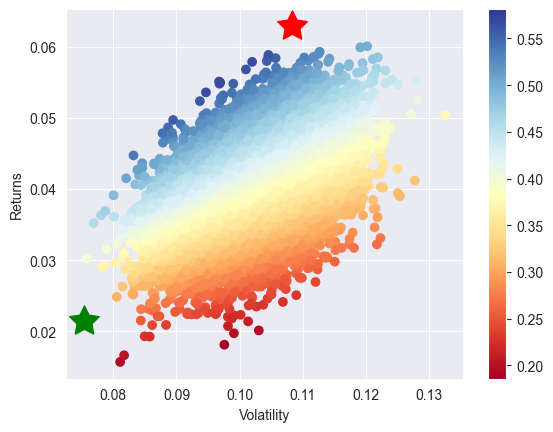

Excel file 'portfolio_weights.xlsx' has been created.


In [9]:
def portfolio_opti(data):
    # calcul des rendements
    returns = data.pct_change()
    # calcul de la matrice de covariance
    mean_daily_returns = returns.mean()
    cov_matrix = returns.cov()
    
    # nombre de portfolios
    num_portfolios = 25000
    

    # on a 3 colonnes : ('ret', 'stdev', 'sharpe') plus le nombre de stocks
    num_stocks = len(data.columns)
    results = np.zeros((3 + num_stocks, num_portfolios))
    
    for i in range(num_portfolios):

        weights = np.array([])
    
        # on continue d générer des poids
        while weights.size == 0 or np.any(weights < 0.01):
            weights = np.random.random(num_stocks)

            weights /= np.sum(weights)
    
        # on fait en sorte que les poids soient >= 1%
        weights[weights < 0.01] = 0.01
        
        weights /= np.sum(weights)
        
        # calcul du return et de la vol
        portfolio_return = np.sum(mean_daily_returns * weights) * 252
        portfolio_std_dev = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights))) * np.sqrt(252)
        
        results[0, i] = portfolio_return
        results[1, i] = portfolio_std_dev
        # on récup le sharpe ratio
        results[2, i] = results[0, i] / results[1, i]
        
        for j in range(len(weights)):
            results[j + 3, i] = weights[j]
    
    column_names = ['ret', 'stdev', 'sharpe'] + list(data.columns)
    results_frame = pd.DataFrame(results.T, columns=column_names)
    # on prend le portfolio qui maximise le sharpe
    max_sharpe_port = results_frame.iloc[results_frame['sharpe'].idxmax()]
    # on prend le portfolio qui minimise la variance
    min_vol_port = results_frame.iloc[results_frame['stdev'].idxmin()]
    
    print("Portfolio with the highest Sharpe Ratio (Red Star):")
    for stock, weight in max_sharpe_port[3:].items():
        print(f"{stock}: {weight:.2%}")
    print("\n")
    
    print("Portfolio with the Minimum Variance (Green Star):")
    for stock, weight in min_vol_port[3:].items():
        print(f"{stock}: {weight:.2%}")
    

    plt.scatter(results_frame.stdev, results_frame.ret, c=results_frame.sharpe, cmap='RdYlBu')
    plt.xlabel('Volatility')
    plt.ylabel('Returns')
    plt.colorbar()
    
    plt.scatter(max_sharpe_port['stdev'], max_sharpe_port['ret'], marker=(5, 1, 0), color='r', s=500)
    
    plt.scatter(min_vol_port['stdev'], min_vol_port['ret'], marker=(5, 1, 0), color='g', s=500)
    portfolios = {
        'Highest Sharpe Ratio': max_sharpe_port,
        'Minimum Variance': min_vol_port
    }

    # on enregistre le dataframe dans un fichier excel
    writer = pd.ExcelWriter('portfolio_weights.xlsx', engine='xlsxwriter')
    
    # chaque portfolio est dans un sheet excel
    for name, portfolio in portfolios.items():
        save_portfolio_to_sheet(writer, portfolio, name)
    
    writer.close()
    print("Excel file 'portfolio_weights.xlsx' has been created.")
    plt.show()
portfolio_opti(big_df)

def save_portfolio_to_sheet(writer, portfolio, sheet_name):
    # on enregistre les poids
    weights = portfolio[3:].values
    isins = portfolio[3:].index
    # on enregistre le portfolio
    portfolio_df = pd.DataFrame({'ISIN': isins, 'Weight': weights})
    # on enregistre le portfolio dans le sheet
    portfolio_df.to_excel(writer, sheet_name=sheet_name, index=False)


print("Excel file 'portfolio_weights.xlsx' has been created.")

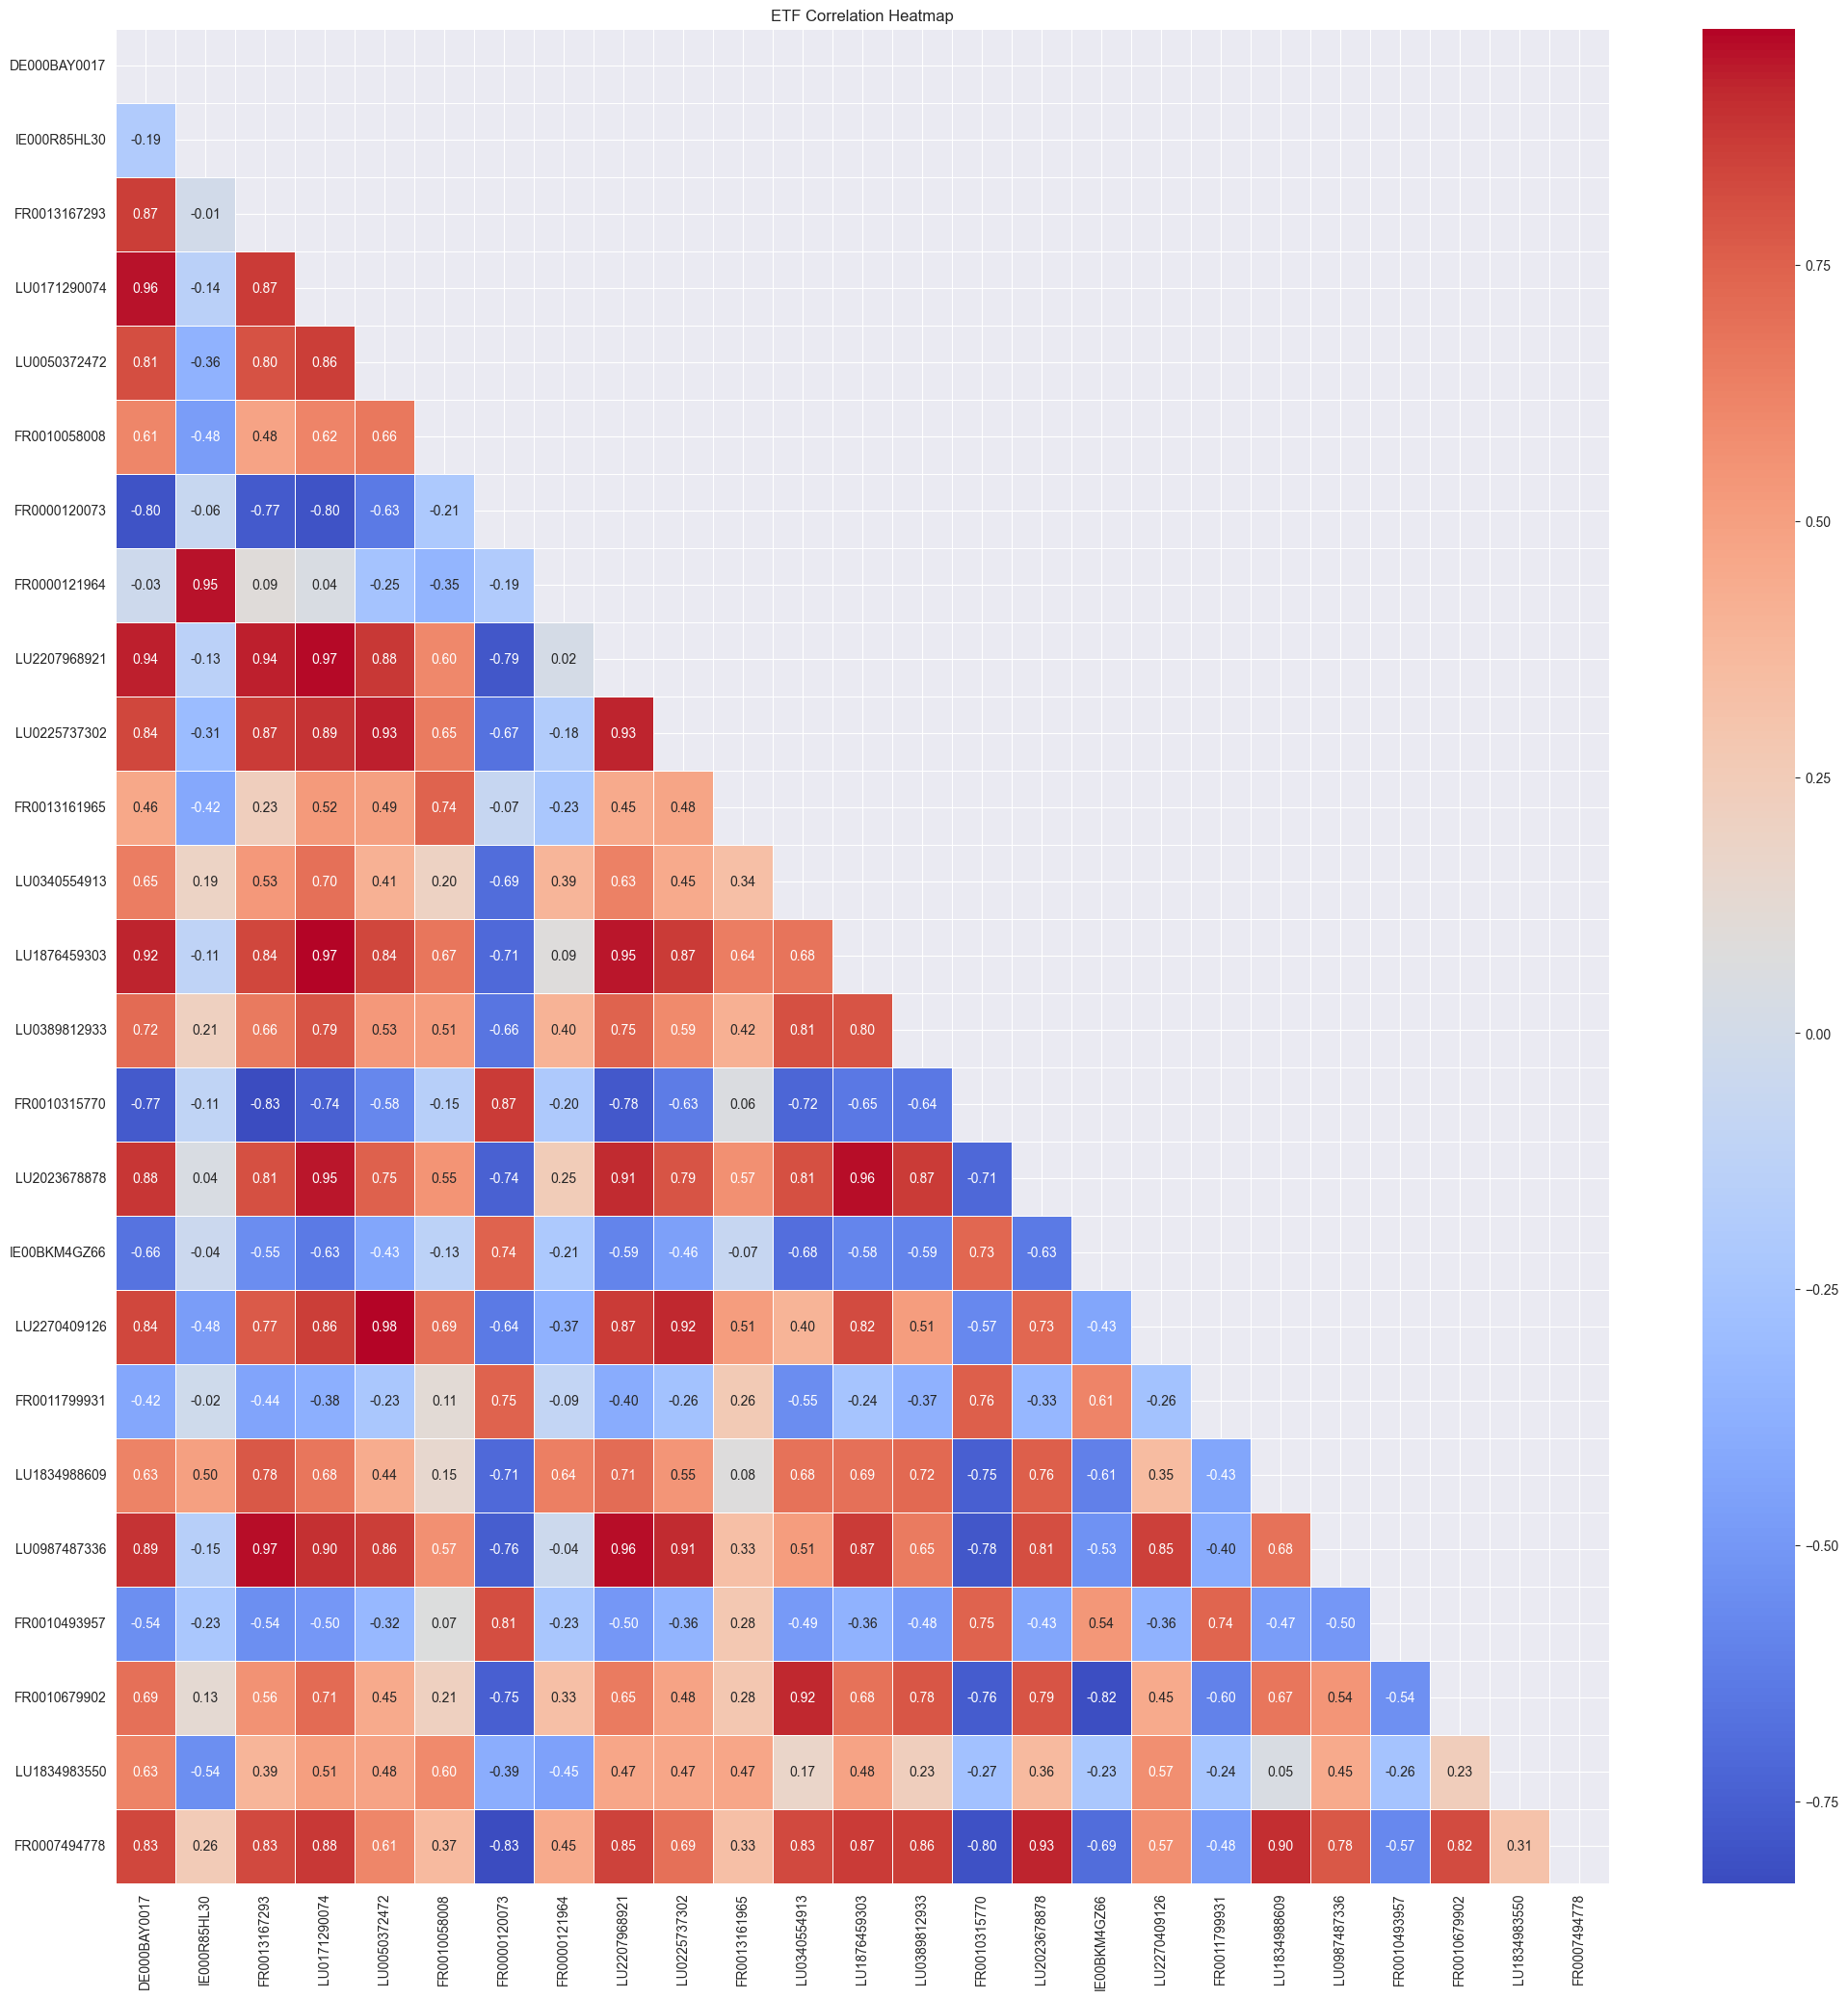

In [94]:
def portfolio_corr_matrix(portfolio):
    correlation_matrix = portfolio.corr()
    mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))
    plt.figure(figsize=(25, 25))
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5, mask=mask)
    plt.title('ETF Correlation Heatmap')
portfolio_corr_matrix(big_df)

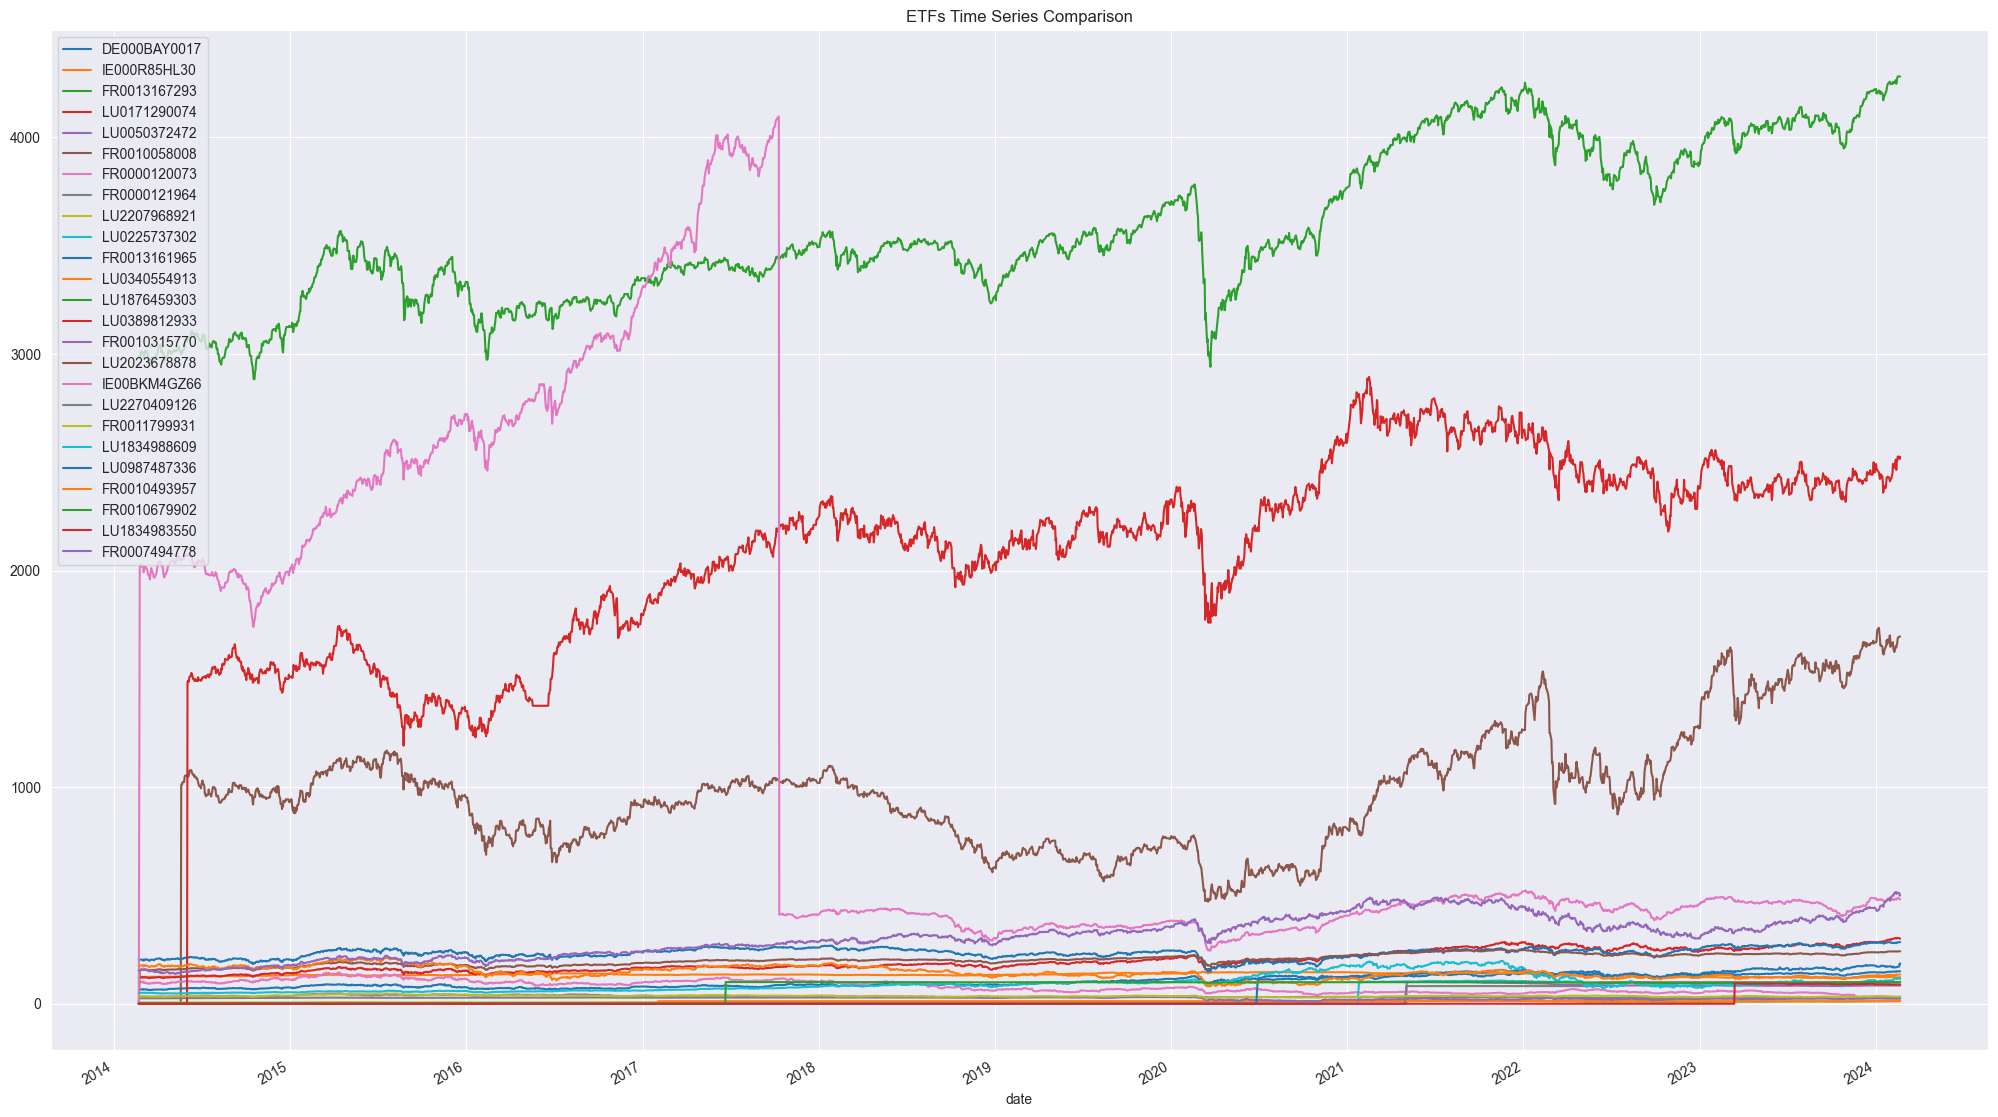

In [96]:
def portfolio_individual_plot(portfolio):
    symbols = list(portfolio.columns)
    plt.figure(figsize=(25, 15))
    for ticker in symbols:
        portfolio[f"{ticker}"].plot(label=ticker)

    plt.title("ETFs Time Series Comparison")
    plt.legend()
portfolio_individual_plot(big_df)

In [95]:
def portfolio_top_corr(portfolio,order = True):
    correlation_values = (portfolio.corr()).unstack()
    sorted_correlation_values = correlation_values[correlation_values != 1.0].sort_values(ascending=order) # on enleve la diagonale
    # on enleve les valeurs duppliquées
    top_correlations = sorted_correlation_values.drop_duplicates()
    
    return top_correlations
portfolio_top_corr(big_df)

FR0007494778  FR0000120073   -0.830085
FR0010315770  FR0013167293   -0.829307
FR0010679902  IE00BKM4GZ66   -0.816386
FR0007494778  FR0010315770   -0.802444
LU0171290074  FR0000120073   -0.801001
                                ...   
LU2023678878  LU1876459303    0.962612
FR0013167293  LU0987487336    0.966433
LU2207968921  LU0171290074    0.967744
LU0171290074  LU1876459303    0.973883
LU0050372472  LU2270409126    0.980832
Length: 300, dtype: float64

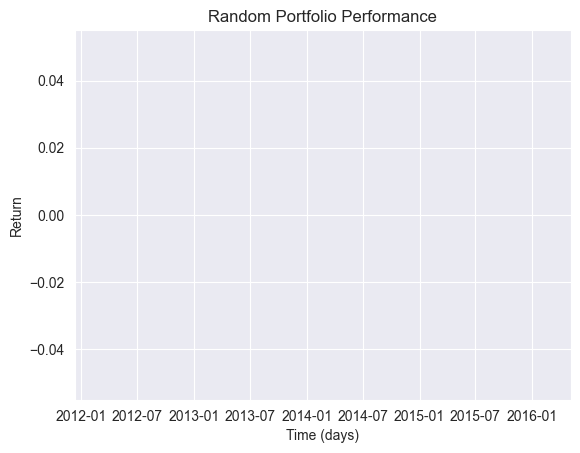

In [97]:
def portfolio_performance(portfolio):
    returns = portfolio.pct_change()
    alphas = .05*np.ones(returns.shape[1])
    portfolio = np.random.dirichlet(alphas, size=1)
    
    plt.plot(returns.fillna(0).dot(portfolio.T).add(1).cumprod().sub(1), color='r')
    plt.title('Random Portfolio Performance')
    plt.xlabel('Time (days)')
    plt.ylabel('Return')
portfolio_performance(big_df)